In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import string
import numpy as np
import random
from sklearn.metrics import classification_report,accuracy_score,balanced_accuracy_score,confusion_matrix

from afinn import Afinn
from collections import defaultdict
sent_lexicon = defaultdict(lambda: 0, Afinn()._dict)

# Ekstra imports
import time
import matplotlib.patches as mpatches
from scipy.linalg import eigh
from scipy import signal
import seaborn as snb
snb.set(font_scale=1.5)

# 1. TEXT CLASSIFICATION: IMDB data

# Load data

In [2]:
df     = pd.read_csv("imdb.csv",index_col=0)

#Data   = df['ShortPlot']
Data   = df['LongPlot']
labels = df['Genre']

np.random.seed(1)
X_train,X_test,y_train,y_test = train_test_split(Data,labels,test_size=0.10,stratify=labels)

n_train_subjects = X_train.shape[0]

In [3]:
categories         = ["Family","Sci-Fi","Thriller", "Romance"]
n_classes          = len(categories)
train_texts        = list(X_train.values)
test_texts         = list(X_test.values)
train_labels_genre = list(y_train.values)
test_labels_genre  = list(y_test.values)
train_title        = list(X_train.index)
test_title         = list(X_test.index)

le = preprocessing.LabelEncoder()
le.fit(categories)

train_labels = le.transform(train_labels_genre)
test_labels = le.transform(test_labels_genre)

#print(train_texts[0],train_labels_genre[0])

#print("Class balances:")
#for i,c in enumerate(categories):
#    print(c,np.mean(train_labels==i))

# GloVe

#### Cleaning the text for GloVe:

In [4]:
def clean(text):
    return text.translate(str.maketrans('', '', string.punctuation)).lower()

In [5]:
# Read Glove file into dictionary
start_time = time.time()
filename = "glove.6B.100d.txt"

dictionary = {}
with open(filename,'r', encoding='utf-8') as file:
    for line in file:
        elements = line.split()
        word = elements[0]
        vector = np.asarray(elements[1:],"float32")
        dictionary[word] = vector

print("Dictionary completed after %s seconds ---" % (time.time() - start_time))

Dictionary completed after 8.525774717330933 seconds ---


#### GloVe embeddings on training and test data (seperately)

In [6]:
# Loop through every word from each movie, and save the movie-vectors
movie_vectors = []
movie_names   = []
for plot, title in zip(train_texts,train_title):

    # clean the text
    words = clean(plot).split()
    
    # iterate through every valid word, and assign them a vector
    word_vectors = []
    for word in words:
        try:
            word_vectors.append(dictionary[word])
        except KeyError:
            #print("Word: '{}' is not in dictionary".format(word))
            continue

    # compute the 'average' word-vector
    movie_vectors.append(np.mean(word_vectors,axis=0))
    movie_names.append(title)

# Convert to numpy array
train_movie_vectors = np.array(movie_vectors)
train_movie_names   = np.array(movie_names)

In [7]:
# Loop through every word from each movie, and save the movie-vectors
movie_vectors = []
movie_names   = []
for plot, title in zip(test_texts,test_title):

    # clean the text
    words = clean(plot).split()
    
    # iterate through every valid word, and assign them a vector
    word_vectors = []
    for word in words:
        try:
            word_vectors.append(dictionary[word])
        except KeyError:
            #print("Word: '{}' is not in dictionary".format(word))
            continue

    # compute the 'average' word-vector
    movie_vectors.append(np.mean(word_vectors,axis=0))
    movie_names.append(title)

# Convert to numpy array
test_movie_vectors = np.array(movie_vectors)
test_movie_names   = np.array(movie_names)

# PCA of movie plots

In [8]:
def compute_pca(vectors):
    
    #pca on feature vectors for selected words
    mean_vector = np.mean(vectors,axis=1)
    data = vectors - mean_vector[:,None]
    
    #compute the covariance matrix
    S = np.cov(data.astype(float), rowvar=False)
    
    #obtain eigenvectors and eigenvalues
    eigenValues, eigenVectors = eigh(S)
    
    #sort according to size of eigenvalues
    eigenValues = eigenValues[::-1]
    eigenVectors = eigenVectors[:, ::-1]
    Y = eigenVectors.T@(data.T)
    return Y, eigenValues, eigenVectors

In [9]:
def plot_pca(Y, word_list,pc1=0,pc2=1):
    #plot for first two principal components
    for label, x, y in zip(word_list, Y[pc1,:], Y[pc2,:]):
        colormap = np.array(['y', 'b', 'g','r'])
        plt.scatter(x,y,c=colormap[label],s=50)
        
        red_patch = mpatches.Patch(color='red', label='Romance')
        
        green_patch = mpatches.Patch(color='green', label='Thriller')
        
        blue_patch = mpatches.Patch(color='blue', label='Sci-Fi')
        
        yellow_patch = mpatches.Patch(color='yellow', label='Family')
        plt.legend(handles=[red_patch,green_patch,blue_patch,yellow_patch])
        
    plt.show()

#### PC1 vs PC2

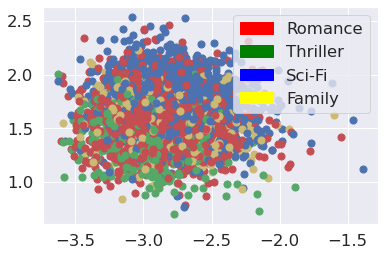

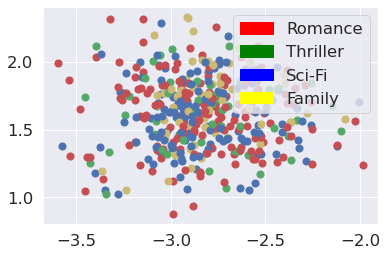

In [10]:
Y, eigenValues, eigenVectors = compute_pca(train_movie_vectors)

# Training
plot_pca(Y,train_labels) 

# Test
plot_pca(Y,test_labels) 

Principal components 2 and 3


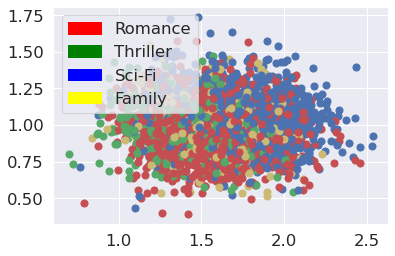

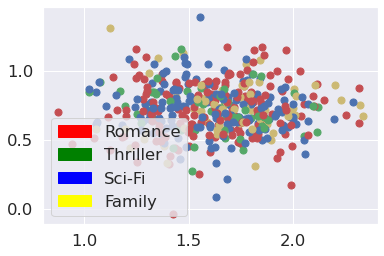

In [11]:
pc = 1
print(f'Principal components {pc+1} and {pc+2}')

# Training
plot_pca(Y,train_labels,pc1=pc,pc2=pc+2) 

# Test
plot_pca(Y,test_labels,pc1=pc,pc2=pc+1) 

# Plot explained variance

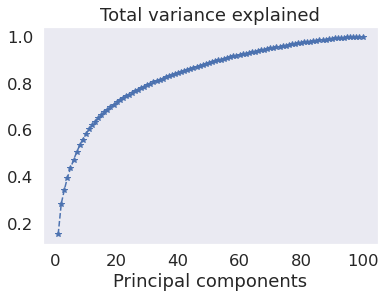

In [12]:
#plot cummulative variance explained    
n_eigenvectors = 100
summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(n_eigenvectors)
for i in range(n_eigenvectors):    
    cumsum = cumsum + eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
plt.plot(range(1,n_eigenvectors+1),total_var_explained,"--*")
plt.grid();
plt.title('Total variance explained')
plt.xlabel('Principal components')
plt.show();

# Classify genres based on the first n principal components of GloVe vectors

In [13]:
K = 40 #number of eigenvectors
subspace    = eigenVectors[:,:K]

X_train_z_  = train_movie_vectors.T
X_test_z_   = test_movie_vectors.T

#project the training data into the subspace generated by the eigenfaces
subspace_features = np.matmul(subspace.T,X_train_z_)

def classify_genre(test_plot_nr,n=1):
    input_plot = (X_test_z_[:,test_plot_nr])
    input_plot_features = np.matmul(subspace.T,input_plot)
    similarity_score = np.zeros(n_train_subjects)
    for n in range(n_train_subjects):
        A = subspace_features[:,n]
        similarity_score[n] = spatial.distance.cosine(A, input_plot_features)
    #bestFitIndex = np.argmin(similarity_score)
    bestFitIndexes = similarity_score.argsort()[:n]
    train_plot_nrs = [train_labels_genre[i] for i in bestFitIndexes]
    return train_plot_nrs, bestFitIndexes

#select a particular test image
test_plot_nr = 87
test_genre   = y_test[test_plot_nr]
#find the training image that is most similar

# plot 5 closest
closest = 5
predict_genres, bestFitIndexes = classify_genre(test_plot_nr,closest)

#plot the two vectoooors
input_plot = (X_test_z_[:,test_plot_nr])
input_plot_features = np.matmul(subspace.T,input_plot)
print(test_title[test_plot_nr])#,input_plot_features)
print()
for i in range(closest):
    print(f'Movie {i+1}; Genre: {predict_genres[i]} -',train_title[bestFitIndexes[i]],'\n')#,subspace_features[:,bestFitIndexes[i]],'\n')


#compute the test test predicted subject number
print('test genre :', test_genre)
print('predicted genre :', predict_genres[0])
if(test_genre == predict_genres[0]):
    print('classified correctly')
else:
    print('miss-classification')

The Matrix Revolutions

Movie 1; Genre: Thriller - Watchmen 

Movie 2; Genre: Thriller - Automata 

Movie 3; Genre: Thriller - Children of Men 

Movie 4; Genre: Sci-Fi - 9 

Movie 5; Genre: Thriller - The Road 

test genre : Thriller
predicted genre : Thriller
classified correctly


In [14]:
start_time = time.time()
test_predictions  = np.array([classify_genre(x)[0][0] for x in range(len(y_test))]) 
test_acc  = np.mean(test_predictions  == np.array(test_labels_genre))
print('Test accuracy:\t\t%4.3f' % test_acc)
print(f"Ended in {time.time() - start_time} seconds")

Test accuracy:		0.519
Ended in 56.720969915390015 seconds


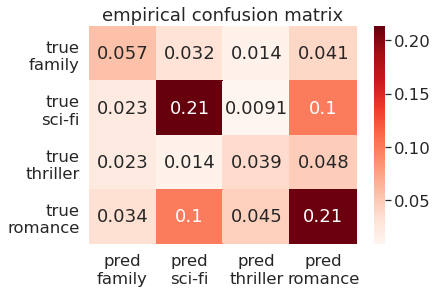

In [15]:
# Confusion matrix:
# 
# TRUE
#               ___________________________________
# family   (0) |______|________|__________|________|
# sci-fi   (1) |______|________|__________|________|
# thriller (2) |______|________|__________|________|
# romance  (3) |______|________|__________|________|
#               family  sci-fi   thriller   romance
#               (0)      (1)       (2)        (3)
#
#                       PREDICT

CM = confusion_matrix(test_labels_genre, test_predictions)
CM_normalized = CM / CM.sum()
snb.heatmap(CM_normalized,yticklabels=['true\nfamily','true\nsci-fi','true\nthriller','true\nromance'],xticklabels=['pred\nfamily','pred\nsci-fi','pred\nthriller','pred\nromance'],annot=True,cmap="Reds")
plt.title('empirical confusion matrix')
plt.show()




# FastText Classification using 3-gram embeddings

In [16]:
#########################################################################################################
# Adapted from: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
#########################################################################################################

import numpy as np
import random
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import TextClassificationDataset
from torchtext.vocab import Vocab
from torchtext.vocab import build_vocab_from_iterator

#####################################################################################################################
# Auxilary functions
#####################################################################################################################

tokenizer = get_tokenizer("basic_english")


def token_iterator(texts, ngrams):
    for text in texts:
        tokens = tokenizer(text)
        yield ngrams_iterator(tokens, ngrams)


def construct_vocab(texts, ngrams):
    vocab = build_vocab_from_iterator(token_iterator(texts, ngrams))
    return vocab


def text_to_tensor(text, vocab, ngrams):
    tokens = ngrams_iterator(tokenizer(text), ngrams=ngrams)
    token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token] for token in tokens]))
    tokens = torch.tensor(token_ids)
    return tokens


def make_torchdataset(vocab, texts, labels, ngrams):
    tokens = [text_to_tensor(text, vocab, ngrams) for text in tqdm(texts)]
    pairs = list(zip(labels, tokens))
    return TextClassificationDataset(vocab, pairs, set(labels))

def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

#####################################################################################################################
# Model
#####################################################################################################################


class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

#####################################################################################################################
# FastText
#####################################################################################################################


class FastText(object):

    def __init__(self, texts, labels, embed_dim, ngrams=3, num_epochs=5, seed=0):

        # set seed
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        #if torch.cuda.is_available():
        #    torch.cuda.manual_seed_all(seed)


        self.texts = texts
        self.labels = labels
        self.embed_dim = embed_dim
        self.ngrams = ngrams

        # construct vocab
        print('Constructing vocabulary...')
        self.vocab = construct_vocab(texts, ngrams)
        self.vocab_size = len(self.vocab)

        # prepare dataset
        print('Preparing dataset...')
        self.train_dataset = make_torchdataset(self.vocab, texts, labels, ngrams)
        self.num_classes = len(self.train_dataset.get_labels())

        # prepare device ref and model
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = torch.device("cpu")
        self.model = TextClassificationModel(self.vocab_size, self.embed_dim, self.num_classes).to(self.device)

        # loss function & optimization
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=4.0)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        self.batch_size = 16

        self.tokenizer = get_tokenizer("basic_english")
        self.ngrams = ngrams



        if num_epochs > 0:
            print('Training model...')
            self.train(self.train_dataset, num_epochs)


    def train_step(self, sub_train_):

        # Train the model
        train_loss = 0
        train_acc = 0
        data = DataLoader(sub_train_, batch_size=self.batch_size, shuffle=True, collate_fn=generate_batch)
        for i, (text, offsets, cls) in enumerate(data):
            self.optimizer.zero_grad()
            text, offsets, cls = text.to(self.device), offsets.to(self.device), cls.to(self.device)
            output = self.model(text, offsets)
            loss = self.criterion(output, cls)
            train_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            train_acc += (output.argmax(1) == cls).sum().item()

        # Adjust the learning rate
        self.scheduler.step()

        return train_loss / len(sub_train_),  train_acc / len(sub_train_)

    def compute_loss(self, data_):
        loss = 0
        acc = 0
        data = DataLoader(data_, batch_size=self.batch_size, collate_fn=generate_batch)
        for text, offsets, cls in data:
            text, offsets, cls = text.to(self.device), offsets.to(self.device), cls.to(self.device)
            with torch.no_grad():
                output = self.model(text, offsets)
                loss = self.criterion(output, cls)
                loss += loss.item()
                acc += (output.argmax(1) == cls).sum().item()

        return loss / len(data_), acc / len(data_)

    def train(self, train_dataset, n_epochs=5):

        min_valid_loss = float('inf')

        for epoch in range(n_epochs):
            start_time = time.time()
            train_loss, train_acc  = self.train_step(train_dataset)

            secs = int(time.time() - start_time)
            mins = secs / 60
            secs = secs % 60

            print('Epoch: %d' % (epoch + 1), " | time in %d minutes, %d seconds" % (mins, secs))
            print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        print('')

    def predict(self, text_, return_prob=False):

        with torch.no_grad():
            text = text_to_tensor(text_, self.vocab, self.ngrams)
            output = self.model(text, torch.tensor([0]))

            if return_prob:
                return F.softmax(output, 1).detach().numpy()
            else:
                return output.argmax(1).item()

    def get_text_embedding(self, text_):
        with torch.no_grad():
            text = text_to_tensor(text_, self.vocab, self.ngrams)
            return self.model.embedding(text, offsets=torch.LongTensor([0])).detach().numpy()

    def word_in_vocab(self, word):
        return word in self.vocab.stoi





In [17]:
# Usage example:
start_time = time.time()
model = FastText(train_texts,train_labels,embed_dim=100,num_epochs=10,ngrams=3)
print("Model trained after %s seconds ---" % (time.time() - start_time))

650lines [00:00, 6494.28lines/s]

Constructing vocabulary...


3964lines [00:00, 4951.53lines/s]
  6%|▋         | 251/3964 [00:00<00:01, 2505.27it/s]

Preparing dataset...


100%|██████████| 3964/3964 [00:01<00:00, 2532.43it/s]


Training model...
Epoch: 1  | time in 0 minutes, 3 seconds
	Loss: 0.0841(train)	|	Acc: 38.7%(train)
Epoch: 2  | time in 0 minutes, 3 seconds
	Loss: 0.0769(train)	|	Acc: 45.2%(train)
Epoch: 3  | time in 0 minutes, 3 seconds
	Loss: 0.0698(train)	|	Acc: 52.2%(train)
Epoch: 4  | time in 0 minutes, 3 seconds
	Loss: 0.0623(train)	|	Acc: 58.1%(train)
Epoch: 5  | time in 0 minutes, 3 seconds
	Loss: 0.0537(train)	|	Acc: 66.6%(train)
Epoch: 6  | time in 0 minutes, 3 seconds
	Loss: 0.0460(train)	|	Acc: 73.5%(train)
Epoch: 7  | time in 0 minutes, 3 seconds
	Loss: 0.0388(train)	|	Acc: 79.9%(train)
Epoch: 8  | time in 0 minutes, 3 seconds
	Loss: 0.0327(train)	|	Acc: 84.3%(train)
Epoch: 9  | time in 0 minutes, 3 seconds
	Loss: 0.0278(train)	|	Acc: 88.4%(train)
Epoch: 10  | time in 0 minutes, 3 seconds
	Loss: 0.0238(train)	|	Acc: 91.3%(train)

Model trained after 39.311996936798096 seconds ---


# Classification on test set

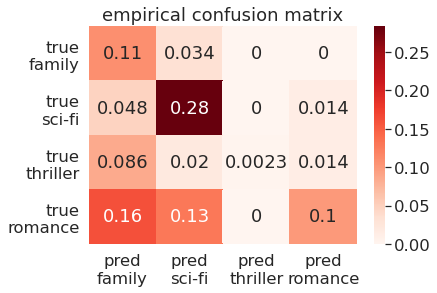

In [18]:
test_predictions  = np.array([model.predict(test_texts[x]) for x in range(len(y_test))])

CM = confusion_matrix(test_labels, test_predictions)
CM_normalized = CM / CM.sum()
snb.heatmap(CM_normalized,yticklabels=['true\nfamily','true\nsci-fi','true\nthriller','true\nromance'],xticklabels=['pred\nfamily','pred\nsci-fi','pred\nthriller','pred\nromance'],annot=True,cmap="Reds")
plt.title('empirical confusion matrix')
plt.show()

# PCA on FastText embeddings
Fuldkommen ligesom før, man i stedet for »movie_vectors«, bruger vi »model.get_text_embedding« for hver film/plot

In [19]:
t = model.get_text_embedding(plot)

def fast_movie_vectors():
    vectors = []
    for text in train_texts:
        vectors.append(model.get_text_embedding(text)[0])
    
    return np.array(vectors)

fast_train_movie_vectors = fast_movie_vectors()

In [20]:
# Just PCA stuff
def compute_pca(vectors):
    
    #pca on feature vectors for selected words
    mean_vector = np.mean(vectors,axis=1)
    data = vectors - mean_vector[:,None]
    
    #compute the covariance matrix
    S = np.cov(data.astype(float), rowvar=False)
    
    #obtain eigenvectors and eigenvalues
    eigenValues, eigenVectors = eigh(S)
    
    #sort according to size of eigenvalues
    eigenValues = eigenValues[::-1]
    eigenVectors = eigenVectors[:, ::-1]
    Y = eigenVectors.T@(data.T)
    return Y, eigenValues, eigenVectors

def plot_pca(Y, word_list,pc1=0,pc2=1):
    #plot for first two principal components
    for label, x, y in zip(word_list, Y[pc1,:], Y[pc2,:]):
        #plt.plot(x,y,"*")
        colormap = np.array(['y', 'b', 'g','r'])
        plt.scatter(x,y,c=colormap[label],s=50)
        
        
        
        green_patch = mpatches.Patch(color='green', label='Thriller')
        
        blue_patch = mpatches.Patch(color='blue', label='Sci-Fi')
        
        yellow_patch = mpatches.Patch(color='yellow', label='Family')
        
        red_patch = mpatches.Patch(color='red', label='Romance')
        
        plt.legend(handles=[red_patch,green_patch,blue_patch,yellow_patch])
        
    plt.show()


FastY, FastEigenValues, FastEigenVectors = compute_pca(fast_train_movie_vectors)

In [21]:
def plot_pca3d(Y, word_list,pc1=0,pc2=1, pc3=2):
    #plot for first two principal components
    
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    
    for label, x, y, z in zip(word_list, Y[pc1,:], Y[pc2,:], Y[pc3,:]):
        
        colormap = np.array(['r', 'g', 'b','y'])

        # Creating plot
        ax.scatter3D(x, y, z, color = colormap[label])
        plt.title("Map of {}, {} and {} prinicipal components".format(pc1+1, pc2+1, pc3+1))
        
        
        red_patch = mpatches.Patch(color='red', label='Romance')
        
        green_patch = mpatches.Patch(color='green', label='Thriller')
        
        blue_patch = mpatches.Patch(color='blue', label='Sci-Fi')
        
        yellow_patch = mpatches.Patch(color='yellow', label='Family')
        plt.legend(handles=[red_patch,green_patch,blue_patch,yellow_patch])
        
        
    plt.show()

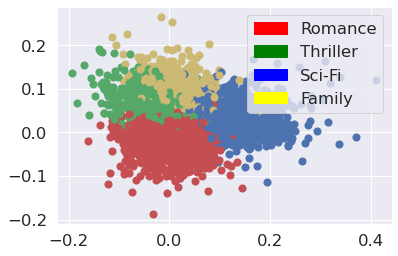

In [22]:
plot_pca(FastY,train_labels)

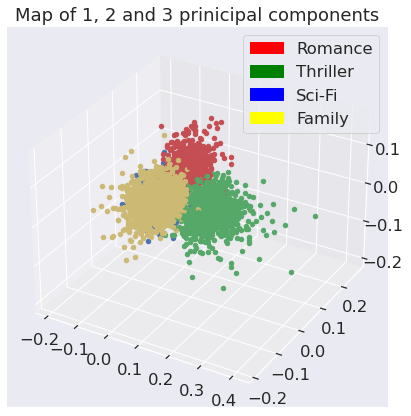

In [23]:
plot_pca3d(FastY,train_labels)

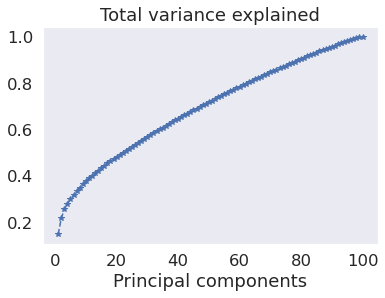

In [24]:
#plot cummulative variance explained    
n_eigenvectors = 100
summ = FastEigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(n_eigenvectors)
for i in range(n_eigenvectors):    
    cumsum = cumsum + FastEigenValues[i]
    total_var_explained[i]=(cumsum/summ)
plt.plot(range(1,n_eigenvectors+1),total_var_explained,"--*")
plt.grid();
plt.title('Total variance explained')
plt.xlabel('Principal components')
plt.show();

In [25]:
K = 100 #number of eigenvectors
subspace    = FastEigenVectors[:,:K]
X_train_z_  = fast_train_movie_vectors.T
X_test_z_   = test_movie_vectors.T

#project the training data into the subspace generated by the eigenfaces
subspace_features = np.matmul(subspace.T,X_train_z_)

def fast_classify_genre(test_plot_nr,N=1):
    input_plot = (X_test_z_[:,test_plot_nr])
    input_plot_features = np.matmul(subspace.T,input_plot)
    similarity_score = np.zeros(n_train_subjects)
    for n in range(n_train_subjects):
        A = subspace_features[:,n]
        similarity_score[n] = spatial.distance.cosine(A, input_plot_features)
    #bestFitIndex = np.argmin(similarity_score)
    bestFitIndexes = similarity_score.argsort()[:N]
    train_plot_nrs = [train_labels_genre[i] for i in bestFitIndexes]
    return train_plot_nrs, bestFitIndexes

In [26]:
start_time = time.time()
test_predictions  = np.array([fast_classify_genre(x)[0][0] for x in range(len(y_test))]) 
test_acc  = np.mean(test_predictions  == np.array(test_labels_genre))
print('Test accuracy:\t\t%4.3f' % test_acc)
print(f"Ended in {time.time() - start_time} seconds")

Test accuracy:		0.381
Ended in 61.2772331237793 seconds


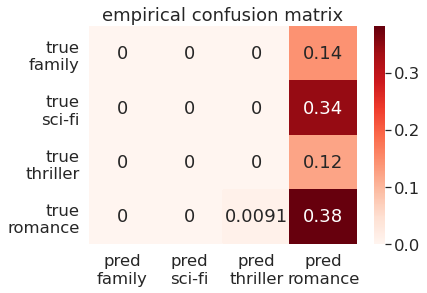

In [27]:
CM = confusion_matrix(test_labels_genre, test_predictions)
CM_normalized = CM / CM.sum()
snb.heatmap(CM_normalized,yticklabels=['true\nfamily','true\nsci-fi','true\nthriller','true\nromance'],xticklabels=['pred\nfamily','pred\nsci-fi','pred\nthriller','pred\nromance'],annot=True,cmap="Reds")
plt.title('empirical confusion matrix')
plt.show()

### There is obviously something wrong here (above). Sadly, we won't have time to fix it.

# Write your own plot and see what genre GloVe+PCA+classifier and FastText guess it is

In [28]:
def single_plot_to_glove(plot):
    words = clean(plot).split()

    # iterate through every valid word, and assign them a vector
    word_vectors = []
    for word in words:
        try:
            word_vectors.append(dictionary[word])
        except KeyError:
            #print("Word: '{}' is not in dictionary".format(word))
            continue

    # compute the 'average' word-vector
    return np.mean(word_vectors,axis=0)

We must redefine classify_genres() to make it work on single plots:

In [29]:
K = 40 #number of eigenvectors
subspace    = eigenVectors[:,:K]

X_train_z_  = train_movie_vectors.T
X_test_z_   = test_movie_vectors.T

#project the training data into the subspace generated by the eigenfaces
subspace_features = np.matmul(subspace.T,X_train_z_)

def classify_genre_single(plot,N=1):
    input_plot = plot
    input_plot_features = np.matmul(subspace.T,input_plot)
    similarity_score = np.zeros(n_train_subjects)
    for n in range(n_train_subjects):
        A = subspace_features[:,n]
        similarity_score[n] = spatial.distance.cosine(A, input_plot_features)
    #bestFitIndex = np.argmin(similarity_score)
    bestFitIndexes = similarity_score.argsort()[:N]
    train_plot_nrs = [train_labels_genre[i] for i in bestFitIndexes]
    return train_plot_nrs, bestFitIndexes

In [30]:
# Insert own plot here
plot = "Matko is a small time hustler, living by the river Danube with his 17 year old son Zare. After a failed business deal he owes money to the much more successful gangster Dadan. Dadan has a sister, Afrodita, that he desperately wants to see get married so they strike a deal: Zare is to marry her. But none of the two care much for an arranged marriage: Zare is in love with Ida, Afrodita is waiting for the man of her dreams"

# FastText
p = model.predict(plot)
print("FASTTEXT PREDICTION")
print(categories[p])
print()

# GloVe
#print(single_plot_to_glove(plot))
c = classify_genre_single(single_plot_to_glove(plot))[0][0]
print('GLOVE PREDICTION')
print(c)

FASTTEXT PREDICTION
Sci-Fi

GLOVE PREDICTION
Romance


#### Compare test plots between GloVe and FastText

In [31]:
index = 10
test_plot = test_texts[index]
print("PLOT:", test_plot)
print(f'\nTRUE CATEGORY: \n{test_labels_genre[index]}\n')

# FastTest
p = model.predict(test_plot)
print("FASTTEXT PREDICTION")
print(categories[p])
print()

# GloVe
c = classify_genre(index)[0][0]
print('GLOVE PREDICTION')
print(c)

PLOT: The adventurous, young Madeline is very good at getting into trouble, but she's also fantastic in solving problems as well, and her school-mistress Miss Clavel is not too approving of her. The biggest problem comes up when Lord Covington decides to sell Madeline's school.

TRUE CATEGORY: 
Family

FASTTEXT PREDICTION
Sci-Fi

GLOVE PREDICTION
Romance


# (2) EXTRA TASK - SENTIMENT ANALYSIS: The Donald

In [32]:
text = np.loadtxt("Donald.txt",dtype='str')
text_cleaned = []
for word in text:
    
    # to lower
    doc_cleaned = word.lower()
    
    #doc_cleaned = ' '.join([word for word in doc_cleaned.split() if word not in stop_words])    
    doc_cleaned = doc_cleaned.replace('.', '')
    doc_cleaned = doc_cleaned.replace(',', '')
    doc_cleaned = doc_cleaned.replace('?', '')
    doc_cleaned = doc_cleaned.replace('!', '')
    text_cleaned.append(doc_cleaned)


# Calculate window-wise sentiment and have the window size and stride as variables that can easily be changed

In [33]:
def text_to_sentiment(document):
    sentiment_list = []
    for t in document:
        sentiment_list.append(sent_lexicon[t])
        
    return sentiment_list

# Version 1: one-sided window
def sentiment_signal_1(document,L=1,J=1):
    signal = []
    for i in range(0,len(document)-L,J):
        
        temp_sum = 0
        for j in range(i,i+L+1):
            temp_sum += document[j]
        
        signal.append(temp_sum)
        
    return np.array(signal)
    
# Version 2: double-sided window
def sentiment_signal_2(document,L=1,J=1):
    signal = []
    for i in range(L,len(document)-L,J):
        
        temp_sum = 0
        for j in range(i-L,i+L):
            temp_sum += document[j]
        
        signal.append(temp_sum)
    
    return np.array(signal)


sentiment_text = np.array(text_to_sentiment(text_cleaned))
sentiment_signal1 = sentiment_signal_1(sentiment_text,7,1)

In [34]:
#print(list(zip(text_cleaned,sentiment_text)))
#print(text_cleaned)
#print(sentiment_text)

# Plot the sentiment over time

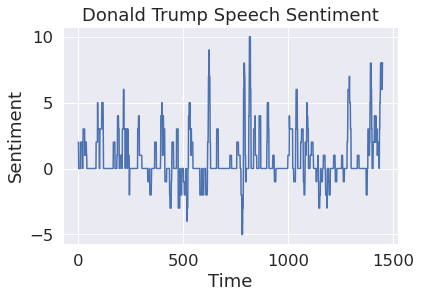

In [35]:
plt.plot(sentiment_signal1)
plt.xlabel('Time') 
plt.ylabel('Sentiment')
plt.title('Donald Trump Speech Sentiment')
plt.show()

# Low pass filter using a smoothing filter

### In practice filter (little amount of code)

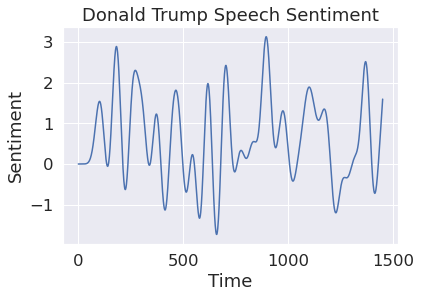

In [36]:
cutoff_lowpass = 15

sos = signal.butter(10, cutoff_lowpass, fs=1000, output='sos', btype='lowpass')
filtered = signal.sosfilt(sos, sentiment_signal1)


plt.plot(filtered)
plt.xlabel('Time') 
plt.ylabel('Sentiment')
plt.title('Donald Trump Speech Sentiment')
plt.show()

### Filtering from scratch

#### 1) Create harmonic basis (discrete fourier transform)

In [37]:
N = sentiment_text.shape[0]

# make sure we have an odd number N
assert N % 2 == 1

ns = np.arange(N)
V = np.zeros((N,N))

freqs = np.arange(int(0.5*N)+1) # Fs = 1, so the last part cancels out

# first basis vector
V[:,0] = np.ones(N)

# remaining basis vectors
n_pairs = int((N-1)/2)
for k in range(1,n_pairs + 1):
    # in each column we are going to define cosine or sine function with frequency k
    V[:,2*k-1] = np.sqrt(2)*np.cos(2*np.pi*ns/N*k) ## at each step we are filling this is a column
    V[:,2*k] = np.sqrt(2)*np.sin(2*np.pi*ns/N*k)

# scale all vectors
V = V/np.sqrt(N)    

#### 2) Transform signal to fourier-domain

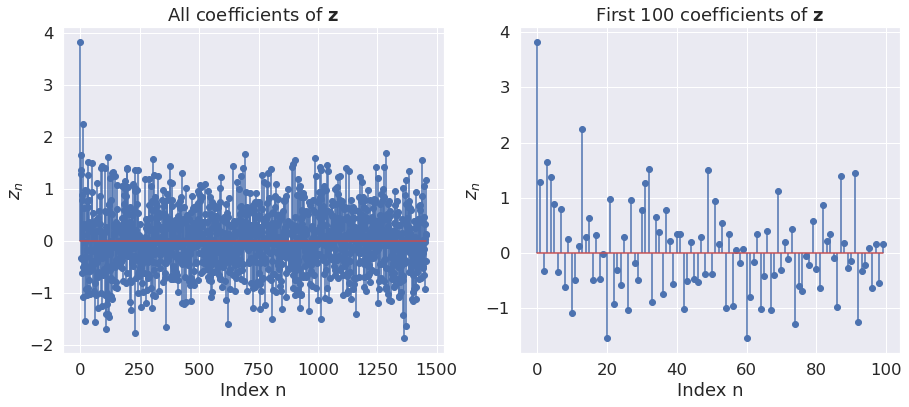

In [38]:
z = V.T@sentiment_text

plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 2, 1)
plt.stem(z)
plt.xlabel('Index n')
plt.ylabel('$z_n$')
plt.title('All coefficients of $\mathbf{z}$')


plt.subplot(1, 2, 2)
plt.stem(z[:100])
plt.xlabel('Index n')
plt.ylabel('$z_n$')
plt.title('First 100 coefficients of $\mathbf{z}$');

#### 3) Apply low-pass filter

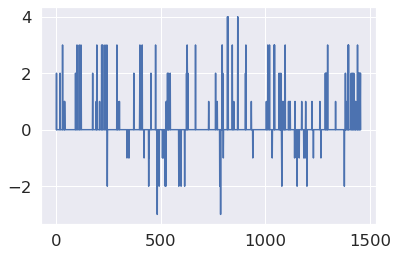

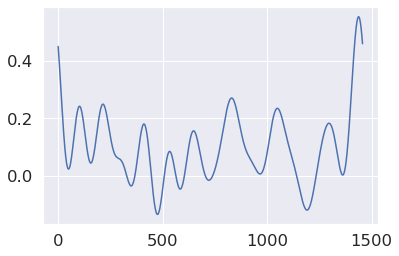

In [39]:
# cut-off frequencies for low-pass filter
cutoff_lowpass = 15

# define mask for amplitude spectrum
spec_lowpass_mask = 1.0*(freqs < cutoff_lowpass)

# convert to z representation
z_lowpass_mask = np.zeros(N)
for k in range(1, n_pairs):
    z_lowpass_mask[2*k] = spec_lowpass_mask[k]
    z_lowpass_mask[2*k-1] = spec_lowpass_mask[k]    
z_lowpass_mask[0] = spec_lowpass_mask[0]

# perform the filtering in the frequency domain
z_lp = z*z_lowpass_mask

# map back to time-domain representation
y_lp = V@z_lp

plt.plot(sentiment_text)
#plt.title('Before')
plt.show()

plt.plot(y_lp)
#plt.title('Lowpass')
plt.show()